In [1]:
import h5py
from New_grass import grassmannian_clustering_gruber2006
from tqdm import tqdm
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import pickle


<div style="text-align:center; font-size:24px;">Loading the eigenvects and clustering data using grassmann clustering</div>

In [2]:
# Only dealing with data from sleep_run's for each subject
# All data has sample size 429
cluster_numbers = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]
number_of_subjects = 33 
run_number = [2, 3, 4, 5] # sleep-run-numbers
all_data_matrices = {} # lib to hold all the sleep_stage data for each subject
valid_data_lib = {} # holds information about each subject and for what sleep stage runs we have data // valid_data_lib['01] - subject 1

for subject in range(1, number_of_subjects + 1):
    subject = str(subject).zfill(2) # fill 01, 02 and so on

    all_data_matrices[subject] = {}
    valid_data_lib[subject] = []

    for number in run_number:
        data_matrix = []
        with open(f"sleep_data/sleep_scores/sub-{subject}-sleep-stage.tsv", "r", newline="", encoding="utf-8") as tsv_file: # needs to do this for every number othervise it does not work
            tsv_reader = csv.reader(tsv_file, delimiter="\t")
            next(tsv_reader) # skip first row to remove column names
            for row in tsv_reader:
                if subject != "01":
                    if row[0] == f'task-sleep_run-{number}': 
                        data_matrix.append(row)
                else:
                    if row[1] == f'task-sleep_run-{number}': # We do this to handle the case where the first collumn is not 'task-sleep_run-x' as is the case for subject 1
                        data_matrix.append(row)   
            if len(data_matrix)>0:        
                all_data_matrices[subject][number] = data_matrix
                valid_data_lib[subject].append(number)

for number in run_number: # removing first collumn in data for subject "01" as it contains an extra collumn compared to the rest of the data
    try: 
        all_data_matrices["01"][number] = [row[1:] for row in all_data_matrices["01"][number]]
    except:
        continue

for subject in all_data_matrices: # removing subjects with no data for sleep stages at all
    numbers_to_remove = []
    for number in valid_data_lib[subject]: # removing sleep runs that contain a constant state 
        if len(np.unique([s[0] for s in np.array(all_data_matrices[subject][number])[:, 2]])) == 1:
            numbers_to_remove.append(number)
    for number in numbers_to_remove:
        valid_data_lib[subject].remove(number)
    if valid_data_lib[subject] == []:
        valid_data_lib.pop(subject)

# removing some subjects manually if they seem to contain to much noise or are awake almost all the time - this will not be caught above
valid_data_lib.pop('11')
valid_data_lib.pop('23')
valid_data_lib.pop('27')
valid_data_lib.pop('20')
valid_data_lib.pop('03')
valid_data_lib.pop('07')

valid_data_lib = {key: value for key, value in valid_data_lib.items() if len(value) >= len(run_number)} # finally we remove all subjects where we dont have valid data for all (4) runs

print(len(valid_data_lib)) # number of subjects left

13


In [3]:
# colleting all data an using vstack to get correct shape
all_data = []

for subject in valid_data_lib:
    for number in valid_data_lib[subject]:
        with h5py.File(f"sleep_data/eigvecs/sub-{subject}_session-task-sleep_run-{number}_eigvecs.h5", "r") as file:
            data = file['eigvecs'][:]
            all_data.append(data)

# Stack all the data vertically
all_data = np.vstack(all_data)

print(all_data.shape, 13*429*4)



(22308, 116, 2) 22308


In [4]:
cluster_assignments_objfunc_cent_num = {}

for i in tqdm(range(10)):
    cluster_assignments_objfunc_cent = {}

    for cluster in tqdm(cluster_numbers):
        cluster_assignments_objfunc_cent[cluster] = {}
        C, obj, part, sub_obj = grassmannian_clustering_gruber2006(all_data, cluster, len(valid_data_lib), max_iter=500)
        cluster_assignments_objfunc_cent[cluster]['C'] = C
        cluster_assignments_objfunc_cent[cluster]['obj'] = obj[-1] # tager kun den bedste obj value efter grassmann terminater
        cluster_assignments_objfunc_cent[cluster]['part'] = part
        cluster_assignments_objfunc_cent[cluster]['obj_sub'] = sub_obj[-1]
        
    cluster_assignments_objfunc_cent_num[i] = cluster_assignments_objfunc_cent

100%|██████████| 10/10 [1:53:04<00:00, 678.45s/it]


<div style="text-align:center; font-size:24px;">Using Objective Function Value as meassure for preformance</div>

<div style="text-align:center; font-size:24px;">Using NMI as meassure for preformance</div>


In [6]:
# bud på en sequence til at fitte 30 sekund intervaller til 429 samples
# sums to 429

sequence = [14, 14, 14, 15, 14, 14, 14, 15, 14, 14, 15, 15, 14, 14, 14, 15, 14, 14, 14, 15, 14, 14, 15, 15, 14, 14, 14, 15, 14, 14]

for subject in valid_data_lib:
    for number in valid_data_lib[subject]:
        repeated_data = np.repeat(np.array(all_data_matrices[subject][number])[:, 2], sequence)
        all_data_matrices[subject][number] = repeated_data   

<div style="text-align:center; font-size:24px;">1 out of K encoding of the true labels</div>

In [7]:
number_of_sleep_stages = 3 # number of possible sleep_stages 

possible_sleep_stages = ['W'] + [str(i) for i in range(1, number_of_sleep_stages)]

# colleting all data an using vstack to get correct shape
encoded_data = []

for subject in valid_data_lib:
    for number in valid_data_lib[subject]:
        subject_matrix = np.zeros((len(possible_sleep_stages), len(all_data_matrices[subject][number])), dtype=int) # this will be (4, 429) as everything is right now
        for i, stage in enumerate(all_data_matrices[subject][number]):
            try: 
                stage_index = possible_sleep_stages.index(stage) # Find the index of the stage in the possible_sleep_stages list
            except:
                try:
                    stage_index = possible_sleep_stages.index(stage[0]) # here we take care of the data very we have '1 uncertain' or 'W uncertain'
                except:
                    stage_index = possible_sleep_stages.index('W') # justify why we do this ///////
            subject_matrix[stage_index, i] = 1 # Set the corresponding element in the subject_matrix to 1
        encoded_data.append(subject_matrix)

# Stack all the data vertically
encoded_data = np.hstack(encoded_data)


<div style="text-align:center; font-size:24px;">1 out of K encoding of predicted labels using grassmann clustering</div>

In [8]:

encoded_predictions = {} # holds 1 out of k encoded predictions

for run in range(10):
    encoded_predictions[run] = {}

    for cluster in cluster_numbers:
        encoded_predictions[run][cluster] = {} # we encode predictions for number of clusters
        possible_clusters = list(range(cluster))
        cluster_matrix = np.zeros((cluster, len(cluster_assignments_objfunc_cent_num[run][cluster]['part']))) # data is the output from the grassmann clustering func
        for i, stage in enumerate(cluster_assignments_objfunc_cent_num[run][cluster]['part']):
            stage_index = possible_clusters.index(stage)
            cluster_matrix[stage_index, i] = 1
        encoded_predictions[run][cluster] = cluster_matrix


<div style="text-align:center; font-size:24px;">Calculating NMI</div>

In [9]:
def calc_MI(Z1, Z2):
    P = Z1 @ Z2.T # joint probability matrix
    PXY = P / np.sum(P) # joint probability matrix normalized
    PXPY = np.outer(np.sum(PXY,axis=1),np.sum(PXY,axis=0)) # product of marginals
    ind = np.where(PXY > 0) # non-zero elements
    MI = np.sum(PXY[ind] * np.log(PXY[ind]/PXPY[ind])) # mutual information
    return MI

def calc_NMI(Z1, Z2):
    # Z1 and Z2 are two partition matrices of size (KxN) where K is number of components and N is number of samples

     ###### to handle runtime error
    if np.mean([calc_MI(Z1,Z1), calc_MI(Z2,Z2)]) == 0:
        return 0

    NMI = calc_MI(Z1,Z2) / np.mean([calc_MI(Z1,Z1), calc_MI(Z2,Z2)])

    return NMI

NMI_scores = {}

for run in range(10):
    NMI_scores[run] = {}
    for cluster in cluster_numbers:
        score = calc_NMI(encoded_data, encoded_predictions[run][cluster])
        NMI_scores[run][cluster] = score

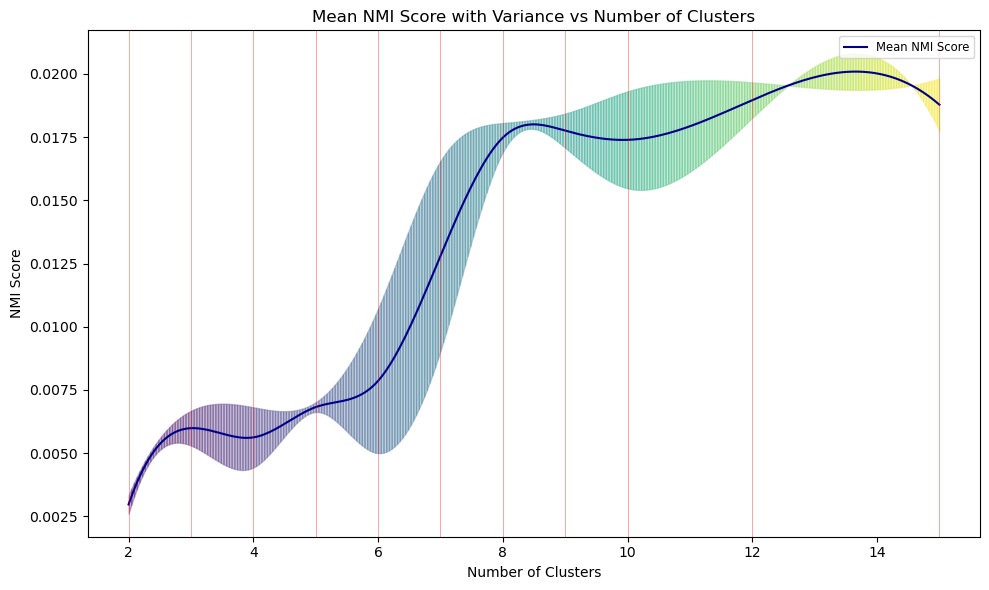

In [10]:
# Create a figure
plt.figure(figsize=(10, 6))

# List to store NMI scores for each cluster
NMI_scores_list = []

# Collect the NMI scores for each cluster across all runs
for cluster in cluster_numbers:
    cluster_scores = [NMI_scores[run][cluster] for run in range(len(NMI_scores))]
    NMI_scores_list.append(cluster_scores)

# Convert to numpy array for easier manipulation
NMI_scores_array = np.array(NMI_scores_list).T

# Compute mean and variance across runs for each number of clusters
mean_values = np.mean(NMI_scores_array, axis=0)
variance_values = np.var(NMI_scores_array, axis=0)
std_dev = np.sqrt(variance_values)

# Interpolation for smoothing
x_smooth = np.linspace(min(cluster_numbers), max(cluster_numbers), 300)  # 300 points for smooth curve

# Create splines for mean and standard deviation
mean_spline = make_interp_spline(cluster_numbers, mean_values, k=3)
std_spline = make_interp_spline(cluster_numbers, std_dev, k=3)

# Evaluate splines
smooth_mean = mean_spline(x_smooth)
smooth_std = std_spline(x_smooth)

# Plot the smoothed mean NMI scores
plt.plot(x_smooth, smooth_mean, label='Mean NMI Score', color='darkblue')

# Fill between for the smooth standard deviation
cmap = plt.get_cmap('viridis')
for i in range(len(x_smooth) - 1):
    plt.fill_between(x_smooth[i:i+2], 
                     smooth_mean[i:i+2] - smooth_std[i:i+2], 
                     smooth_mean[i:i+2] + smooth_std[i:i+2],
                     color=cmap(i / len(x_smooth)), 
                     alpha=0.3)

# Add thin vertical and slightly transparent red lines at each number of clusters
for cluster in cluster_numbers:
    plt.axvline(x=cluster, color='red', linestyle='-', linewidth=0.5, alpha=0.5)

# Add labels and title
plt.xlabel('Number of Clusters')
plt.ylabel('NMI Score')
plt.title('Mean NMI Score with Variance vs Number of Clusters')
plt.grid(False)
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()


In [12]:
with open('data_10runs.pkl', 'wb') as f:
    pickle.dump(cluster_assignments_objfunc_cent_num, f)